# Logistic Regression Study

On this classic Machine Learning beginer´s challenge I´ll  be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

The deal here is basic try to predict a classification - survival or deceased - on the passangers list.

This study can basically be divided in three parts:
* Exploratory Data Analysis (EDA)
* Data Cleaning
* Modeling and evaluating results

## Importing All Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the train.csv file into a pandas dataframe.

In [2]:
titanic_train = pd.read_csv('train.csv')
titanic_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Exploratory Data Analysis

As we can see from the head above, there are various features such as sex, age and "Pclass" wich we could find relations regard the Survived Status, let´s take a look but first we need to verify holes and missing data in our data frame.

### Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data... as we can see above

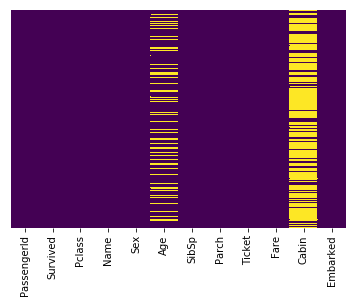

In [3]:
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [4]:
titanic_train['Age'].isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. 

Let's continue on by visualizing some more of the data! 

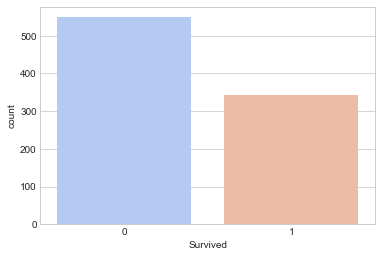

In [5]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=titanic_train,palette='coolwarm')

Let´s plot the same counting but distinguishing the survivors by sex.

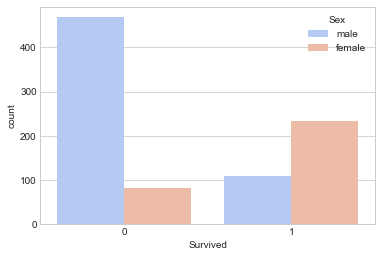

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=titanic_train,palette='coolwarm')

And also, by in which class they were travelling

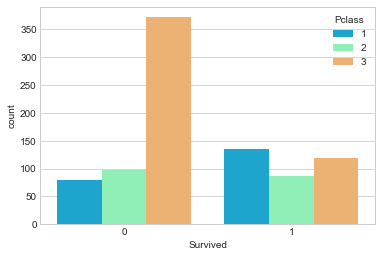

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=titanic_train,palette='rainbow')

From these plots we can argue that beeing male or in third class, could significantly decrease your chances of surviving the crash.

Now, let´s take a look in the age distribution among passangers

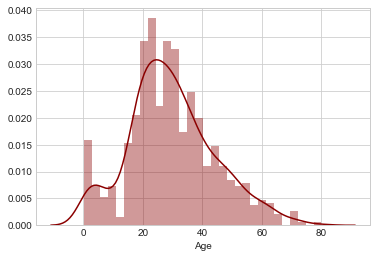

In [8]:
sns.distplot(titanic_train['Age'].dropna(),kde=True,color='darkred',bins=30)

Let´s also see the count on the number of relatives onboard and the distribuiton of money spent on the fare.

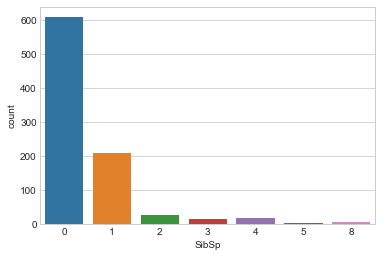

In [9]:
sns.countplot(x='SibSp',data=titanic_train)

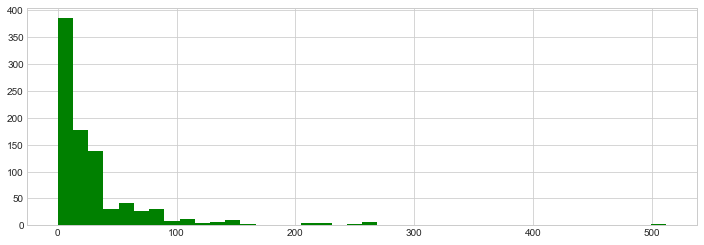

In [10]:
titanic_train['Fare'].hist(color='green',bins=40,figsize=(12,4))

## Data Cleaning

We want to fill in missing age data instead of just dropping the missing age data rows. A far way to do this would be filling in the mean age of all the passengers (imputation).

However let´s first check the average age by passenger class and sex. For example:


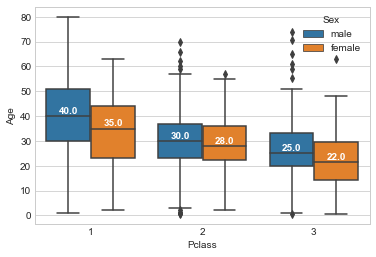

In [11]:
testPlot = sns.boxplot(x='Pclass', y='Age', hue='Sex', data=titanic_train)
m1 = titanic_train.groupby(['Pclass', 'Sex'])['Age'].median().values
mL1 = [str(np.round(s, 0)) for s in m1]

ind = 0
for tick in range(len(testPlot.get_xticklabels())):
    testPlot.text(tick-.2, m1[ind+1]+1, mL1[ind+1],  horizontalalignment='center',  color='w', weight='bold')
    testPlot.text(tick+.2, m1[ind]+1, mL1[ind], horizontalalignment='center', color='w', weight='bold')
    ind += 2    
plt.show()

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass and Sex for Age.

In [12]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    Sex = cols[2]
    
    if pd.isnull(Age):

        if Pclass == 1:
            if Sex == 'male':
                return 40
            else:
                return 35

        elif Pclass == 2:
            if Sex == 'male':
                return 30
            else:
                return 28

        else:
            if Sex == 'male':
                return 25
            else:
                return 22
    else:
        return Age

Now apply that function!

In [13]:
titanic_train['Age'] = titanic_train[['Age','Pclass','Sex']].apply(impute_age,axis=1)

Now let's check that heat map again!

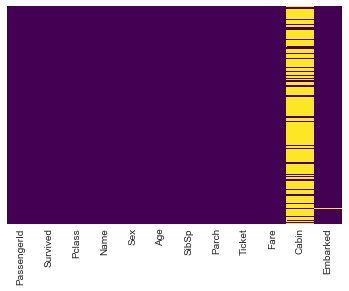

In [14]:
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Let´s re-check the age distribution and see if we still have gaussian alike curve.

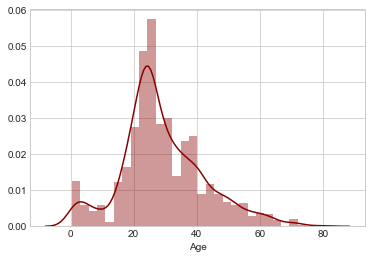

In [15]:
sns.distplot(titanic_train['Age'].dropna(),kde=True,color='darkred',bins=30)

On the Cabin column, we need a different approach since we have a lot less information.
So we´ll redifine all values as "known" or "unknown"

In [16]:
def k_or_u(value):
    a = value
    if pd.isnull(a):
        return 'unknown'
    else:
        return 'known'

In [17]:
titanic_train['Cabin'] = titanic_train['Cabin'].apply(k_or_u)

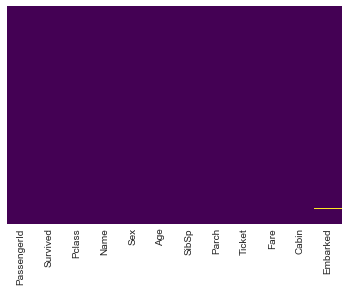

In [18]:
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

We still have one missing value at the column "Embarked" so let´s drop that

In [19]:
titanic_train.dropna(inplace=True)

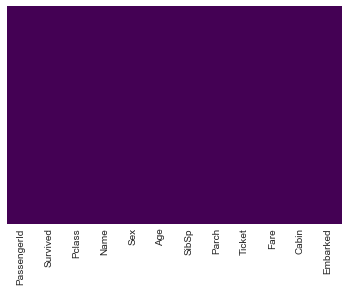

In [20]:
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Name to simply Treatment Pronouns

Below we can see that all inputs in the column 'Name' contain some treatment pronoun

In [21]:
titanic_train['Name'].head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Let´s grab only these pronouns

In [22]:
def get_pronoun(name):
    a = name.split()
    for pron in a:
        if '.' in pron:
            return pron

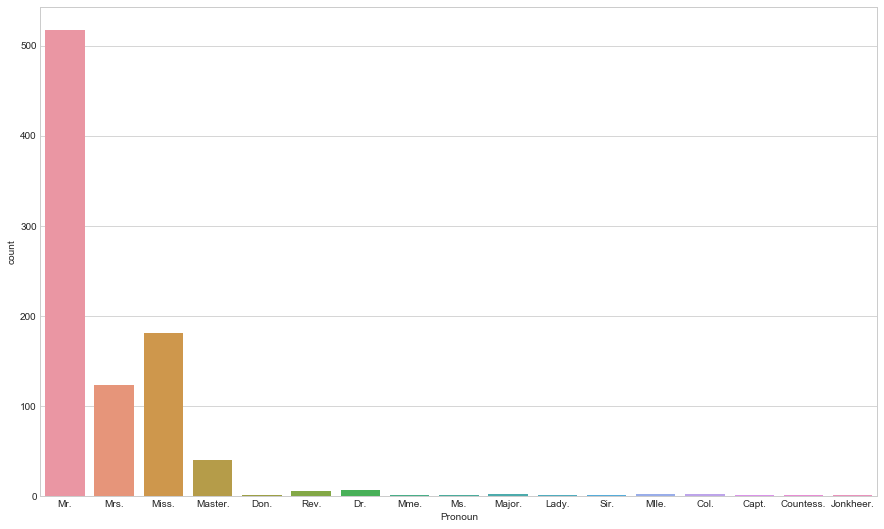

In [23]:
titanic_train['Pronoun'] = titanic_train['Name'].apply(get_pronoun)
plt.figure(figsize=(15,9))
sns.countplot(x='Pronoun', data= titanic_train)

### Converting Categorical Features 

Now we need to convert categorical features to dummy variables using pandas! Otherwise the  algorithm won't be able to directly take in those features as inputs.

In [24]:
sex = pd.get_dummies(titanic_train['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_train['Embarked'],drop_first=True)
cabin_info = pd.get_dummies(titanic_train['Cabin'],drop_first=True)
pronouns = pd.get_dummies(titanic_train['Pronoun'],drop_first=True)

In [25]:
titanic_train.drop(['Sex','Embarked','Cabin','Name','Pronoun','Ticket'],axis=1,inplace=True)

In [26]:
titanic_train = pd.concat([titanic_train,sex,embark,cabin_info,pronouns],axis=1)

In [49]:
titanic_train.head(10)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,...,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.,Sir.
0,1,0,3,22.0,1,0,7.2500,1,0,1,...,0,0,0,0,0,1,0,0,0,0
1,2,1,1,38.0,1,0,71.2833,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,35.0,1,0,53.1000,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,5,0,3,35.0,0,0,8.0500,1,0,1,...,0,0,0,0,0,1,0,0,0,0
5,6,0,3,25.0,0,0,8.4583,1,1,0,...,0,0,0,0,0,1,0,0,0,0
6,7,0,1,54.0,0,0,51.8625,1,0,1,...,0,0,0,0,0,1,0,0,0,0
7,8,0,3,2.0,3,1,21.0750,1,0,1,...,0,1,0,0,0,0,0,0,0,0
8,9,1,3,27.0,0,2,11.1333,0,0,1,...,0,0,0,0,0,0,1,0,0,0
9,10,1,2,14.0,1,0,30.0708,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Great! The data is ready for the model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set

## Train Test Split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train.drop('Survived',axis=1), 
                                                    titanic_train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
predictions = logmodel.predict(X_test)

Let's move on to evaluate our model!

## Evaluation

In [33]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.85      0.93      0.89       163
          1       0.88      0.74      0.80       104

avg / total       0.86      0.86      0.86       267



** Our Model had a 86% 